In [2]:

df = pd.read_csv('info.csv')
df.head()

,Unnamed: 0,id,description,latitude,longitude,stationDataOriginList
0,0,1,INTA - La Viña,-25.472397,-65.567772,[]
1,1,2,UCASAL - El Tipal,-24.765795,-65.475501,[]
2,2,3,UCASAL - Fac. Ingeniería,-24.740442,-65.391771,"[{'id': 26, 'externalStationId': 'ISALTA11', '..."
3,3,4,UCASAL - Colegio Belgrano,-24.781080,-65.409908,"[{'id': 24, 'externalStationId': 'ISALTA7', 'd..."
4,4,5,UCASAL - La Caldera,-24.610000,-65.390000,"[{'id': 25, 'externalStationId': 'ILACAL8', 'd..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             105 non-null    int64  
 1   id                     105 non-null    int64  
 2   description            105 non-null    object 
 3   latitude               105 non-null    float64
 4   longitude              105 non-null    float64
 5   stationDataOriginList  105 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 5.0+ KB


In [4]:
df['stationDataOriginList'][2]


"[{'id': 26, 'externalStationId': 'ISALTA11', 'dimension': {'id': 3, 'description': 'lluvia', 'preferredUnit': {'id': 3, 'alias': 'mm', 'description': 'milimetro'}}, 'dataOrigin': {'id': 2, 'description': 'WeatherUnderground'}, 'defaultUnit': {'id': 4, 'alias': 'in', 'description': 'pulgada'}}]"

In [5]:
pd.DataFrame(json.loads(df['stationDataOriginList'][2].replace("\'", "\"")))

,id,externalStationId,dimension,dataOrigin,defaultUnit
0,26,ISALTA11,"{'id': 3, 'description': 'lluvia', 'preferredU...","{'id': 2, 'description': 'WeatherUnderground'}","{'id': 4, 'alias': 'in', 'description': 'pulga..."


In [17]:
import requests
import base64
import json
import pandas as pd

def make_request(url, username, password, from_date, to_date, data={}):
    # Construct the headers for the API request
    headers = {
        'content-type': 'application/json;charset=UTF-8',
        'authorization': f'Basic {base64.b64encode(f"{username}:{password}".encode()).decode()}'
    }
    
    # Construct the payload for the API request
    payload = {
        'from': from_date,
        'to': to_date,
        **data
    }
    
    # Make the API request
    response = requests.post(url, headers=headers, data=json.dumps(payload))
    
    # Check the response status code
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")
    
    # Parse the response JSON data
    data = json.loads(response.text)
    
    # Flatten any nested objects or arrays in the data
    flattened_data = []
    for record in data:
        flattened_record = {}
        for key, value in record.items():
            if isinstance(value, dict):
                for subkey, subvalue in value.items():
                    flattened_record[f"{key}_{subkey}"] = subvalue
            elif isinstance(value, list):
                for i, item in enumerate(value):
                    for subkey, subvalue in item.items():
                        flattened_record[f"{key}_{i}_{subkey}"] = subvalue
            else:
                flattened_record[key] = value
        flattened_data.append(flattened_record)
    
    # Convert the flattened data to a pandas DataFrame
    df = pd.DataFrame(flattened_data)
    
    # Return the DataFrame
    return df


In [25]:
url = 'https://ci03.simtlix.com/api/rain-accumulation'
username = 'monitor'
password = 'SaltaLaLinda01'
from_date = '2021-10-01T11:23:23'
to_date = '2021-10-07T11:23:23'
data = {}

df = make_request(url, username, password, from_date, to_date, data)


Exception: API request failed with status code 504: <html>
<head><title>504 Gateway Time-out</title></head>
<body>
<center><h1>504 Gateway Time-out</h1></center>
<hr><center>nginx</center>
</body>
</html>


In [ ]:
def dividir_diccionario(diccionario):
    id_ = diccionario['id']
    description = diccionario['description']
    otra_columna = None  # asigna aquí el valor que desees para otra_columna
    return pd.Series({'id': id_, 'description': description, 'otra_columna': otra_columna})

nuevo_df = df['diccionarios'].apply(dividir_diccionario)
df = df.join(nuevo_df)


In [131]:
df

,stationId,rainAccumulationList_0_dataOrigin,rainAccumulationList_0_accumulation
0,13,"{'id': 1, 'description': 'AES'}",307.200012
1,15,"{'id': 1, 'description': 'AES'}",1706.000000
2,16,"{'id': 1, 'description': 'AES'}",16.948999
3,12,"{'id': 1, 'description': 'AES'}",10.670000
4,19,"{'id': 2, 'description': 'WeatherUnderground'}",214.376000
...,...,...,...
66,101,NaN,NaN
67,102,NaN,NaN
68,8,NaN,NaN
69,10,NaN,NaN


In [138]:
df['rainAccumulationList_0_dataOrigin'].value_counts()

{'id': 2, 'description': 'WeatherUnderground'}    13
{'id': 5, 'description': 'INTA_Anterior'}         10
{'id': 3, 'description': 'INTA'}                   7
{'id': 1, 'description': 'AES'}                    6
Name: rainAccumulationList_0_dataOrigin, dtype: int64

In [28]:
import requests
import base64

def get_observations_data(observation_id, sensor_id, size=20, page=0, start_date=None, end_date=None, username=None, password=None):
    url = f"https://ci03.simtlix.com/api/observations/{observation_id}/{sensor_id}"
    params = {'size': size, 'page': page}
    headers = {'Content-Type': 'application/json;charset=UTF-8'}
    if username and password:
        credentials = f"{username}:{password}"
        encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('utf-8')
        headers['Authorization'] = f"Basic {encoded_credentials}"
    if start_date and end_date:
        data = {'from': start_date, 'to': end_date}
        response = requests.get(url, params=params, headers=headers, json=data)
    else:
        response = requests.get(url, params=params, headers=headers)
    response.raise_for_status() # throws an error if response status is not 2xx
    return response.json()


df = get_observations_data(observation_id=22, sensor_id=1, start_date="2021-10-01T03:00:00", end_date="2021-10-01T23:59:59", username='monitor', password='SaltaLaLinda01')


HTTPError: 504 Server Error: Gateway Time-out for url: https://ci03.simtlix.com/api/observations/22/1?size=20&page=0

In [32]:
#Santo tome id = 271, 6542

import requests

response = requests.get(url= 'https://alerta.ina.gob.ar/pub/datos/datos&timeStart=2023-08-23&timeEnd=2023-08-24&varId=2&siteCode=1679&')
df = response.json()
df

{'title': 'Mensaje de error',
 'mensaje': 'No se encontraron resultados que coincidan con los criterios',
 'requestHeader': {'request': 'datos',
  'timeStart': '2023-08-23',
  'timeEnd': '2023-08-24',
  'varId': '2',
  'siteCode': '1679'}}

In [10]:
import requests
import pandas as pd

def obtener_info_json_desde_url(url):
    try:
        # Realizar la solicitud GET a la URL
        response = requests.get(url)
        
        # Verificar si la solicitud fue exitosa
        if response.status_code == 200:
            # Obtener los datos JSON de la respuesta
            datos_json = response.json()
            return datos_json
        else:
            print("Error al obtener la página:", response.status_code)
            return None
    except requests.exceptions.RequestException as e:
        print("Error de conexión:", e)
        return None

# URL de ejemplo
url_ejemplo = 'https://alerta.ina.gob.ar/pub/datos/datos&timeStart=2007-01-01&timeEnd=2023-12-31&seriesId=30&varId=2&format=json'
#url_ejemplo = 'https://alerta.ina.gob.ar/pub/datos/estaciones&redId=10&type=H&format=json'

# Obtener los datos JSON desde la URL
datos_json = obtener_info_json_desde_url(url_ejemplo)

if datos_json:
    # Extraer datos de la sección 'data'
    data_list = datos_json['data']

    # Crear un DataFrame
    df = pd.DataFrame(data_list)

    # Mostrar el DataFrame
    print(df)


           obs_id            timestart              timeend  valor  \
0     21627666958  2007-01-01T12:00:00  2007-01-01T12:00:00   3.60   
1     21627666959  2007-01-02T12:00:00  2007-01-02T12:00:00   3.60   
2     21627666960  2007-01-03T12:00:00  2007-01-03T12:00:00   3.60   
3     21627666961  2007-01-04T12:00:00  2007-01-04T12:00:00   3.60   
4     21627666962  2007-01-05T12:00:00  2007-01-05T12:00:00   3.62   
...           ...                  ...                  ...    ...   
8323  22229005510  2023-12-27T00:00:00  2023-12-27T00:00:00   5.24   
8324  22230639896  2023-12-28T00:00:00  2023-12-28T00:00:00   5.18   
8325  22232267331  2023-12-29T00:00:00  2023-12-29T00:00:00   5.12   
8326  22233893394  2023-12-30T00:00:00  2023-12-30T00:00:00   5.09   
8327  22235911658  2023-12-31T00:00:00  2023-12-31T00:00:00   5.03   

                      timeupdate  
0     2022-11-14T08:53:09.209872  
1     2022-11-14T08:53:09.209872  
2     2022-11-14T08:53:09.209872  
3     2022-11-14T08

In [11]:
# df.to_csv('../datos/metadata_prefectura.csv', index=False)

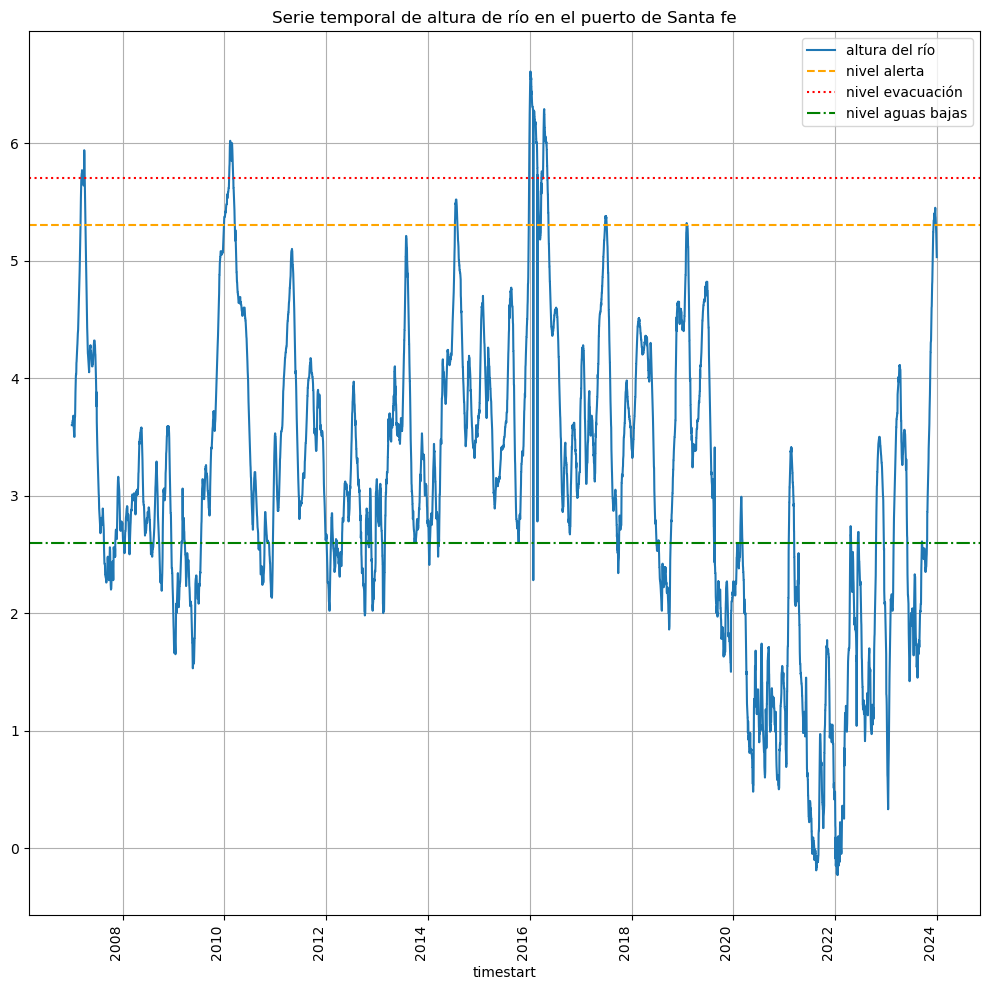

In [24]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,10))
pd.DataFrame(df['valor']).set_index(df['timestart']).valor.plot(label='altura del río')
plt.axhline(5.3, color='orange', linestyle='--', label='nivel alerta')
plt.axhline(5.7, color='red', linestyle=':', label='nivel evacuación')
plt.axhline(2.6, color='green', linestyle='-.', label='nivel aguas bajas')
plt.xticks(rotation=90)
plt.grid()
plt.title('Serie temporal de altura de río en el puerto de Santa fe')
plt.legend()
plt.tight_layout()

In [14]:
df.timestart = pd.to_datetime(df.timestart)

In [15]:
df

,obs_id,timestart,timeend,valor,timeupdate
0,21627666958,2007-01-01 12:00:00,2007-01-01T12:00:00,3.60,2022-11-14T08:53:09.209872
1,21627666959,2007-01-02 12:00:00,2007-01-02T12:00:00,3.60,2022-11-14T08:53:09.209872
2,21627666960,2007-01-03 12:00:00,2007-01-03T12:00:00,3.60,2022-11-14T08:53:09.209872
3,21627666961,2007-01-04 12:00:00,2007-01-04T12:00:00,3.60,2022-11-14T08:53:09.209872
4,21627666962,2007-01-05 12:00:00,2007-01-05T12:00:00,3.62,2022-11-14T08:53:09.209872
...,...,...,...,...,...
8323,22229005510,2023-12-27 00:00:00,2023-12-27T00:00:00,5.24,2023-12-27T12:00:56.57375
8324,22230639896,2023-12-28 00:00:00,2023-12-28T00:00:00,5.18,2023-12-28T12:00:58.565745
8325,22232267331,2023-12-29 00:00:00,2023-12-29T00:00:00,5.12,2023-12-29T12:00:59.709729
8326,22233893394,2023-12-30 00:00:00,2023-12-30T00:00:00,5.09,2023-12-30T12:00:57.705751


In [16]:
df.to_csv('../datos/altura_de_rio_puerto_sta_fe_2007-2023.csv', index=False)